In [32]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical, normalize
import random

In [10]:
train = pd.read_csv('./train.csv')
train

ZCGTAXTYP FORNECEDOR  ZCGDOCREF  VLR_FATURA  DIAS_ENTRE_ACAO_VENC  \
0            BR2  BOA_VISTA          1       53.78                  43.0   
1            BR2  BOA_VISTA          1       42.27                  21.0   
2            BR2  BOA_VISTA          1       21.66                  31.0   
3            BR2  BOA_VISTA          2      109.68                  28.0   
4            BR2  BOA_VISTA          2       63.06                  42.0   
...          ...        ...        ...         ...                   ...   
410683       BR2  BOA_VISTA          2      307.92                  28.0   
410684       BR2  BOA_VISTA          1       40.44                  33.0   
410685       BR2  BOA_VISTA          1       64.89                  37.0   
410686       BR2  BOA_VISTA          1      828.27                  35.0   
410687       BR2  BOA_VISTA          1      233.93                  16.0   

                   FORM_PAGT       CLASSE TARIFA  BAIXARENDA ZCGTIPLOC  \
0       Ficha de compensação  RESIDENCIAL     B1       False       URB   
1       Ficha de compensação  RESIDENCIAL     B1        True       URB   
2           Código de barras  RESIDENCIAL     B1       False       URB   
3       Ficha de compensação  RESIDENCIAL     B1       False       URB   
4       Ficha de compensação  RESIDENCIAL     B1        True       URB   
...                      ...          ...    ...         ...       ...   
410683  Ficha de compensação  RESIDENCIAL     B1        True       URB   
410684  Ficha de compensação  RESIDENCIAL     B1        True       URB   
410685      Código de barras  RESIDENCIAL     B1        True       RUR   
410686      Código de barras  RESIDENCIAL     B1       False       URB   
410687  Ficha de compensação  RESIDENCIAL     B1       False       URB   

        HST_DIAS_ENTRE_ACAO_PGTO  IDADE_CONTA  FLG_ACAO_EFICAZ  
0                           11.0         2540                0  
1                           12.0         4714                1  
2                           57.0          227                1  
3                           28.5          408                0  
4                            7.0         4586                1  
...                          ...          ...              ...  
410683                      12.0         4650                1  
410684                      19.0         2042                1  
410685                      46.0         3832                1  
410686                      10.0         4663                1  
410687                     299.0         1841                1  

[410688 rows x 13 columns]

In [121]:
"""
neo_analytics.custom_keras.utils
================================
Utilitarian functions and custom layer to preprocess data.

This module is capable of transforming structured data into a format that can be
used by the Keras library to create neural network models. Moreover,
it allows connecting the preprocessing step into the model, as one of its
layers.

Quick Reference
---------------
* Use the `convert_df_to_datasets` function to convert a Pandas DataFrame into
  a tensorflow dataset.
* Use the `normalize_numerical_feature` function to normalize a single
  numerical feature.
* Use the `normalize_numerical_features` function to normalize a group of
  numerical features at once.
* Use the `normalize_categorical_feature` function to normalize a single
  categorical feature.
* Use the `normalize_categorical_features` function to normalize a group of
  categorical features at once.
* To apply all normalization functions at once, please referer to the custom
  layer class `PreprocessingLayer`.

All the encoding and normalization functions previously referred to, require
the user to first determine which dataframe columns are categorical and numerical.
Additionally, these functions require the usage of the tensorflow dataset
API, meaning that the user must first convert the pandas dataframe to such
format.

Convert Dataframe to Datasets
-----------------------------
The function `convert_df_to_datasets` allows the conversion of a pandas dataframe
to a tensorflow API dataset.

Normalize Numerical Features
----------------------------
The function `normalize_numerical_features` normalizes a list of used-defined
numerical features in a dataset.

Encode Categorical Features
---------------------------
The function `encode_categorical_features` encodes a list of used-defined
categorical features in a dataset.

Custom Preprocessing Layer
--------------------------
The class `PreprocessingLayer`, allows the preprocessing of an input
pandas dataframe, automatically converting it to a tensorflow API dataset.
Additionally, it allows the automatic normalization of numerical features, and
the automatic encoding its categorical counterpart.

Overview of the dataset API
---------------------------
This module uses the TensorFlow dataset API. The motivation behind using the
dataset API, is motivated by the fact that it enables the definition of the
preprocessing layers, as a direct component of the final model. When all data
preprocessing is part of the model, it enables others to load and use any
model you make, without requiring them to be aware of how each feature is
expected to be encoded & normalized. Performance also plays a role in this
decision, although it is not the motivation behind this shift in paradigm.

For more information on the benefits of defining the preprocessing layers, as
model components, please refer to the following link:

* `https://keras.io/guides/preprocessing_layers/#benefits-of-doing-preprocessing-inside-the-model-at-inference-time`_

Common Terms
^^^^^^^^^^^^
Please refer to the following definitions, of common terms, used by the
tensorflow dataset API:

* **Element:** A single output from calling `next()` on a dataset iterator.
  Elements may be nested structures containing multiple components. For
  example, the element (1, (3, "apple")) has one tuple nested in another
  tuple. The components are 1, 3, and "apple".

                (1, (3, "apple"))
                │   └────┰─────┤
                │    (Element) │
                └──────┰───────┘
                   (Element)

* **Component:** The leaf in the nested structure of an element.

                  Component
                     ↑
                (1, (3, "apple"))
                 ↓         ↓
             Component Component

.. warning::

    The class `PreprocessingLayer` relies heavily on the `adapt` method,
    from the `keras` preprocessing layers API. This method however, might
    lead to long loading times. In future versions, the custom layer class,
    is going to support custom keyword arguments for the preprocessing layers
    customization. The `vocabulary` is one of such arguments, and its usage
    should be preferred over the `adapt` method, when encoding categorical
    features.

.. seealso::

    * Quickstart tensorflow dataset API: `https://www.tensorflow.org/guide/data`_
    * Keras preprocessing layers: `https://keras.io/api/layers/preprocessing_layers/`_
    * Keras Layers API: `https://keras.io/api/layers/`_
    * Keras Structured data Examples: `https://keras.io/examples/#structured-data`_

"""
from __future__ import annotations

import warnings
from collections.abc import KeysView
from typing import Any, Dict, List, Tuple, Union

import pandas as pd
import tensorflow as tf

__all__ = [
    "df_to_dataset",
    "get_normalization_layers",
    "get_category_encoding_layers",
    "PreprocessingLayer",
    "str_to_list",
    "get_normalization_layer",
    "get_category_encoding_layer",
]


def df_to_dataset(
    dataframe: pd.DataFrame,
    target_feature_name: str | None = None,
    shuffle: bool = True,
    batch_size: int = 32,
) -> tf.data.Dataset:
    """Convert a Pandas DataFrame to a TensorFlow Dataset.

    Parameters
    ----------
    dataframe : pd.DataFrame
        Pandas DataFrame to be converted to a TensorFlow Dataset.
    target_feature_name : str | None, optional
        Name of the target feature. If `None`, the target feature is not
        included in the dataset.
    shuffle : bool, optional
        Whether to shuffle the dataset. Defaults to `True`.
    batch_size : int, optional
        Batch size. Defaults to 32.

    Returns
    -------
    tf.data.Dataset
        TensorFlow Dataset.

    .. seealso::

        * `tf.data.Dataset`: `https://www.tensorflow.org/api_docs/python/tf/data/Dataset`_

    """
    df = dataframe.copy()

    labels = None

    if isinstance(target_feature_name, str) and target_feature_name in df.columns:
        labels = df.pop(target_feature_name)

    df = {key: value[:, tf.newaxis] for key, value in dataframe.items()}
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
        ds = ds.batch(batch_size)
        ds = ds.prefetch(batch_size)
    return ds


def get_ds_features(dataset: tf.data.Dataset) -> List[KeysView]:
    """Get the list of features in a dataset.

    To convert a pandas DataFrame to a TensorFlow Dataset, use the function
    :func:`df_to_dataset`.

    Parameters
    ----------
    dataset : tf.data.dataset
        API that supports writing descriptive and efficient input pipelines.

    Returns
    -------
    List[KeysView]
        List of features from the dataset.

    Examples
    --------
    The following example shows the usage of this function:

    .. code-block:: python

        import pandas as pd
        df = pd.DataFrame({"a": [1, 2, 3], "b": [4, 5, 6]})
        ds = df_to_dataset(df)
        features = get_ds_features(ds)
        print(features)
        # ['a', 'b']

        # If defining dataset with a target feature:
        ds = df_to_dataset(df, target_feature_name='b')
        features = get_ds_features(ds)
        print(features)
        # ['a']

    """
    [(features, _)] = dataset.take(1)
    return list(features.keys())


def get_normalization_layer(
    name: str,
    dataset: tf.data.Dataset,
    axis: int | None = None,
) -> tf.keras.layers.Normalization:
    """Get a normalization layer for a numerical feature.

    Parameters
    ----------
    name : str
        Numerical feature name.
    dataset : tf.data.Dataset
        API that supports writing descriptive and efficient input pipelines.
    axis : int | None, optional
        The axis to normalize. If `None`, the mean and variance are computed
        over all dimensions (e.g., the batch dimension for images).

    Returns
    -------
    tf.keras.layers.Normalization
        Numerical feature normalization layer.
    """
    normalizer = tf.keras.layers.Normalization(axis=axis)
    feature_ds = dataset.map(lambda x, y: x[name])
    normalizer.adapt(feature_ds)

    return normalizer


# TODO: add support for `TextVectorization` layer.
def get_category_encoding_layer(
    name: str,
    dataset: tf.data.Dataset,
    dtype: str,
    vocabulary: List[str] | None = None,
    max_tokens: int | None = None,
):
    """
    Get a multi-hot encoding layer for a categorical feature.

    Parameters
    ----------
    name : str
        Categorical feature name.
    dataset : tf.data.Dataset
        API that supports writing descriptive and efficient input pipelines.
    dtype : str
        The data type of the respective categorical feature. If `dtype` is not
        `string`, it is assumed that the feature contains integer
        categorical values.
    vocabulary: List[str] | None, optional
        Vocabulary of possible values for the categorical feature. If `None`,
        the vocabulary is inferred from the dataset using the `adapt` method.
        Using the `adapt` method might be slow.
    max_tokens : int | None, optional
        Maximum number of tokens to be used in the multi-hot encoding.

    Returns
    -------
    Callable
        A multi-hot encoding layer, that encodes the categorical feature values.

    .. important::

        If you find yourself working with a very large vocabulary in a
        TextVectorization, a StringLookup layer, or an IntegerLookup layer,
        you should avoid using `adapt()`, due to performance issues. Instead,
        pre-compute your vocabulary in advance (you could use Apache Beam or
        TF Transform for this) and store it in a file. Typically,
        a vocabulary larger than 500MB would be considered "very large".

    .. seealso::

        `Tensorflow Dataset API <https://www.tensorflow.org/guide/data>`_

    """
    if dtype == "string":
        index = tf.keras.layers.StringLookup(
            max_tokens=max_tokens, vocabulary=vocabulary
        )
    else:
        index = tf.keras.layers.IntegerLookup(
            max_tokens=max_tokens, vocabulary=vocabulary
        )

    # Prepare a `tf.data.Dataset` that only yields the feature.
    feature_ds = dataset.map(lambda x, y: str(x[name]))

    # Learn the set of possible values and assign them a fixed integer index.
    # This is a slow operation, used when the user doesn't specify a value
    # for the vocabulary parameter.
    if vocabulary is None:

        warnings.simplefilter("once", category=UserWarning)
        warnings.warn(
            "Using `adapt()` is not recommended for large vocabularies. Pass "
            "`vocabulary` to `get_category_encoding_layer()` instead.",
            category=UserWarning,
        )
        index.adapt(feature_ds)

    encoder = tf.keras.layers.CategoryEncoding(num_tokens=index.vocabulary_size())

    # Apply the "multi-hot" encoding to the indices. The lambda function captures
    # the layer, so you can use them, or include them in the Keras Functional
    # model later.
    return lambda feature: encoder(index(feature))


def get_category_encoding_layers(
    categorical_features_names: List[str] | str,
    dataset: tf.data.Dataset,
    max_tokens: int = 5,
    **kwargs: Any,
) -> Tuple[List, List]:
    """
    Encode categorical features using a "multi-hot" encoding layer.

    Function calls the :func:`get_category_encoding_layer` function for each
    of the specified categorical features.

    Parameters
    ----------
    categorical_features_names: List[str] | str
        List of categorical features names.
    dataset: tf.data.Dataset
        Dataset to be encoded.
    max_tokens: int, optional
        Maximum number of tokens to be used in the multi-hot encoding.
        Defaults to 5.
    **kwargs: Any
        Additional keyword arguments are passed to the
        :func:`get_category_encoding_layer`. The following keyword arguments
        can be used to control the encoding behaviour:

            * `vocabularies`: Dict[str, List[str]]
                Dictionary of vocabulary for each categorical feature. If
                defined, use the `categorical_features_names` as keys and the
                its respective vocabulary as value.
            * `dtypes`: Dict[str, str]
                Dictionary of data types for each categorical feature. If
                defined, use the `categorical_features_names` as keys and the
                its respective data type as value. The default value is
                `"string"`, if not specified.

    Returns
    -------
    Tuple[List, List]
        List of categorical features names and list of categorical features
        encoders.

    Raises
    ------
    ValueError
        If :param:`categorical_features_names` is not a list or a string,
        with the categorical features names.

    .. note::

        After using this function, combine the returning `all_inputs` list to
        the rest of the normalized input features.

    """
    all_inputs, encoded_features = [], []

    vocabularies = kwargs.get("vocabularies", {})
    dtypes = kwargs.get("dtypes", {})

    if isinstance(categorical_features_names, str):
        categorical_features_names = [categorical_features_names]

    if not isinstance(categorical_features_names, list):
        raise ValueError(
            'The parameter "categorical_features_names" must be a list of '
            "strings or a string. These strings should represent the name of "
            "the categorical features in your dataset. Parameter of type "
            f'"<{type(categorical_features_names)}>" was passed.'
        )
    num_cat_feats = len(categorical_features_names)

    for index, categorical_feature in enumerate(categorical_features_names):
        print(
            f"({index+1}/{num_cat_feats}) Encoding categorical feature: "
            f'"{categorical_feature}"'
        )
        vocabulary = vocabularies.get(categorical_feature, None)
        dtype = dtypes.get(categorical_feature, "string")

        categorical_col = tf.keras.Input(
            shape=(1,),
            name=categorical_feature,
            dtype=dtype,
        )

        encoding_layer = get_category_encoding_layer(
            name=categorical_feature,
            dataset=dataset,
            dtype="string",
            max_tokens=max_tokens,
            vocabulary=vocabulary,
        )
        encoded_categorical_col = encoding_layer(categorical_col)
        all_inputs.append(categorical_col)
        encoded_features.append(encoded_categorical_col)

    return all_inputs, encoded_features


def get_normalization_layers(
    numerical_features_names: List[str] | str, dataset: tf.data.Dataset
) -> Tuple[List, List]:
    """
    Normalize numerical features.

    Function calls the :func:`get_normalization_layer` function for each
    of the specified numerical features.

    Parameters
    ----------
    numerical_features_names: List[str] | str
        List of numerical features names.
    dataset: tf.data.Dataset
        Dataset to be encoded.

    Returns
    -------
    Tuple[List, List]
        List of numerical features names and list of numerical features
        encoders.

    Raises
    ------
    ValueError
        If :param:`numerical_features_names` is not a list or a string,
        with the numerical features names.

    .. note::

        After using this function, combine the returning `all_inputs`
        list to the rest of the normalized input features.

    """
    all_inputs, encoded_features = [], []

    if isinstance(numerical_features_names, str):
        numerical_features_names = [numerical_features_names]

    if not isinstance(numerical_features_names, list):
        raise ValueError(
            'The parameter "numerical_features_names" must be a list of '
            "strings or a string. These strings should represent the name of "
            "the numerical features in your dataset. Parameter of type "
            f'"<{type(numerical_features_names)}>" was passed.'
        )
    num_numerical_feats = len(numerical_features_names)

    for index, numerical_feature_name in enumerate(numerical_features_names):
        print(
            f"({index + 1}/{num_numerical_feats}) Normalizing feature: "
            f'"{numerical_feature_name}"'
        )
        numeric_col = tf.keras.Input(shape=(1,), name=numerical_feature_name)
        normalization_layer = get_normalization_layer(numerical_feature_name, dataset)
        encoded_numeric_col = normalization_layer(numeric_col)
        all_inputs.append(numeric_col)
        encoded_features.append(encoded_numeric_col)

    return all_inputs, encoded_features


def str_to_list(str_value: str | List[str] | None = None) -> List[Union[str, None]]:
    """
    Convert parameter :param:`str_value` to a list if it is a string.

    Parameters
    ----------
    str_value : str | List[str] | None, optional
        String or list of strings. If None, return an empty list.

    Returns
    -------
    List[Union[str, None]]
        List of strings or empty list.

    Raises
    ------
    ValueError
        If :param:`str_value` is not a string or a list of strings, or None.
    """
    if isinstance(str_value, str):
        return [str_value]
    if isinstance(str_value, list):
        return str_value
    if str_value is None:
        return []
    raise ValueError(
        f"The parameter 'str_value' must be a string or a list of strings or "
        f"None. Parameter of type '<{type(str_value)}>' was passed."
    )


def get_categorical_features_vocab(
    df: pd.DataFrame,
    categorical_features_names: List[Union[str, None]] | str,
) -> Dict[str, List[str]] | Dict:
    """
    Get the vocabulary of the categorical features.

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe to be encoded. Dataframe is where the categorical features
        unique vocabularies are extracted from.
    categorical_features_names : List[Union[str, None]] | str
        List of categorical features names, or a string with the name of a
        categorical feature, or an empty list, if no categorical features
        exist.

    Returns
    -------
    Dict[str, List[str]] | Dict
        Dictionary with the categorical features names as keys and the
        categorical features unique vocabularies as values. If no categorical
        features exist, return an empty dictionary.
    """
    categorical_features_names = str_to_list(categorical_features_names)
    if categorical_features_names:
        return {
            categorical_feature_name: sorted(
                list(df[categorical_feature_name].unique())
            )
            for categorical_feature_name in categorical_features_names
        }
    return {}


class PreprocessingLayer(tf.keras.layers.Layer):
    """
    Preprocessing layer.

    Custom layer class normalizes numerical features, and encodes categorical ones.
    Use this layer's output to feed the rest of the model. You can build the
    rest of the model using the `keras` composition API.

    Only features from `categorical_features_names` and
    `numerical_features_names` that exist inside the `df` parameter are
    processed.

    All categorical columns from the input dataframe :param:`df` are
    converted to strings, prior to the model features processing.

    Parameters
    ----------
    df: pd.DataFrame
        Dataframe to be encoded.
    target_feature_name: str
        Name of the target feature.
    categorical_features_names: List[str] | str | None, optional
        List of categorical features names.
    numerical_features_names: List[str] | str | None, optional
        List of numerical features names, or a string with the name of a
        single numerical feature.

    Examples
    --------
    The following code demonstrates how to use this custom layer, to build a
    model with the `keras` composition API:

    .. code-block:: python

        import random            # For creating random data
        import tensorflow as tf  # Tensorflow 2.0
        import pandas as pd      # Pandas package

        # Define data to populate the example dataframe
        categorical_values = 'ABCDEFGH'
        nrows = 100
        categorical_columns = ['CAT1', 'CAT2', 'CAT3']
        numerical_columns = ['NUM1', 'NUM2', 'NUM3']
        target_column = ['TARGET']

        # Create the example dataframe
        df = pd.DataFrame(
            {
                **{
                    cat_col: [random.choice(categorical_values) for _ in range(nrows)]
                    for cat_col in categorical_columns
                }, **{
                    num_col: [random.random() for _ in range(nrows)]
                    for num_col in numerical_columns
                }, **{
                    target_column: [random.choice([0, 1]) for _ in range(nrows)]
                }
            }
        )
        # Initialize the custom layer
        preprocessing_layer = PreprocessingLayer(
            df, target_column, categorical_columns, numerical_columns
        )
        # Build the rest of the model using the composition API.
        all_features = preprocessing_layer.call()
        dense_1 = tf.keras.layers.Dense(32, activation='relu', name='dense1')(all_features)
        dropout_1 = tf.keras.layers.Dropout(0.5, name='dropout1')(dense_1)
        dense_2 = tf.keras.layers.Dense(64, activation='relu', name='dense2')(dropout_1)
        dense_3 = tf.keras.layers.Dense(32, activation='relu', name='dense3')(dense_2)
        dense_4 = tf.keras.layers.Dense(16, activation='relu', name='dense4')(dense_3)
        output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(dense_4)
        model = tf.keras.Model(all_inputs, output)
        model.compile(
            optimizer='adam',
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
            metrics=["accuracy"]
        )
        # Plot the model layers architecture
        tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

        # Train the model
        history = model.fit(preprocessing_layer.dataset, epochs=50)

    The preceding example should run "as-is", and does not require any additional
    code.

    """

    find_categorical_features_vocab: bool = True
    _dataframe: pd.DataFrame | None = None
    _dataset: tf.data.Dataset | None = None

    @property
    def dataset(self) -> tf.data.Dataset:
        """Returns the dataset."""
        return self._dataset

    @dataset.setter
    def dataset(self, dataset: tf.data.Dataset):
        """Sets the dataset instance.
        
        Parameters
        ----------
        dataset: tf.data.Dataset
            The dataset to be used.
        
        Raises
        ------
        TypeError
            If the `dataset` parameter is not an instance of `tf.data.Dataset`.
        """
        if not isinstance(dataset, tf.data.Dataset):
            cls_name = self.__class__.__name__
            raise TypeError(
                f'The property "dataset" must be an instance of '
                f'tf.data.Dataset, not "{type(dataset)}". If you made changes '
                f'to the initialization structure of the class '
                f'"{cls_name}", please be sure that the updated structure '
                f'defines the "dataset" property, and that it\'s value '
                f'consists of an instance of TensorFlow dataset API.'
            )
        self._dataset = dataset
        
    @property
    def dataframe(self) -> pd.DataFrame:
        """Returns the dataframe."""
        return self._dataframe
    
    @dataframe.setter
    def dataframe(self, dataframe: pd.DataFrame):
        """Sets the dataframe.
        
        Parameters
        ----------
        dataframe: pd.DataFrame
            The dataset to be used.
        
        Raises
        ------
        TypeError
            If the `dataframe` parameter is not an instance of `pd.DataFrame`.
        """
        if isinstance(dataframe, pd.DataFrame):
            self._dataframe = dataframe
        else:
            raise TypeError(
                f'The dataframe must be a pandas.DataFrame, not '
                f'{type(dataframe)}.'
            )

    def __init__(
        self,
        df: pd.DataFrame,
        target_feature_name: str,
        categorical_features_names: List[str] | str | None = None,
        numerical_features_names: List[str] | str | None = None,
        **kwargs: Any,
    ) -> None:
        for kwarg, value in kwargs.items():
            setattr(self, kwarg, value)

        super(PreprocessingLayer, self).__init__()
        self.categorical_features_names = [
            categorical_feature_name
            for categorical_feature_name in str_to_list(categorical_features_names)
            if categorical_feature_name in df.columns
        ]
        self.numerical_features_names = [
            numerical_feature_name
            for numerical_feature_name in str_to_list(numerical_features_names)
            if numerical_feature_name in df.columns
        ]
        self.astype_dict = {
            **{
                categorical_feature_name: str
                for categorical_feature_name in self.categorical_features_names
            },
            **{
                numerical_feature_name: float
                for numerical_feature_name in self.numerical_features_names
            },
        }
        self.df = df.astype(self.astype_dict)
        self.categorical_features_vocab = get_categorical_features_vocab(
            self.df, self.categorical_features_names
        )
        self.dataset = df_to_dataset(self.df, target_feature_name)
        numerical_inputs, encoded_numerical_feats = get_normalization_layers(
            numerical_features_names=self.numerical_features_names,
            dataset=self.dataset,
        )
        categorical_inputs, encoded_categorical_feats = get_category_encoding_layers(
            categorical_features_names=self.categorical_features_names,
            dataset=self.dataset,
            vocabularies=self.categorical_features_vocab,
        )
        self.all_inputs = numerical_inputs + categorical_inputs
        self.encoded_features = encoded_numerical_feats + encoded_categorical_feats

    def get_inputs(self) -> List[tf.Tensor]:
        """Returns the inputs."""
        if hasattr(self, 'all_inputs'):
            return self.all_inputs
        raise AttributeError(
            f'The attribute "all_inputs" is not defined. Are you sure that you '
            f'properly initialized this class?'
        )
    
    def __call__(self) -> tf.Tensor:
        """
        Return layer with all input features normalized and encoded.

        Categorical and numerical features are concatenated.

        Returns
        -------
        tf.Tensor
            Tensor with all input features normalized and encoded.
        """
        return tf.keras.layers.concatenate(self.encoded_features, name='concatenate')


In [74]:
numerical_features_names.difference(['FLG_ACAO_EFICAZ'])

Index(['DIAS_ENTRE_ACAO_VENC', 'HST_DIAS_ENTRE_ACAO_PGTO', 'IDADE_CONTA',
       'VLR_FATURA', 'ZCGDOCREF'],
      dtype='object')

In [77]:
all_inputs = []
encoded_features = []

# Numerical features.
numerical_features_names = [
    'DIAS_ENTRE_ACAO_VENC', 'HST_DIAS_ENTRE_ACAO_PGTO', 'IDADE_CONTA', 'VLR_FATURA', 'ZCGDOCREF'
]

for header in numerical_features_names:
    print(f'Normalizing feature: "{header}"')
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)


Normalizing feature: "DIAS_ENTRE_ACAO_VENC"
Normalizing feature: "HST_DIAS_ENTRE_ACAO_PGTO"
Normalizing feature: "IDADE_CONTA"
Normalizing feature: "VLR_FATURA"
Normalizing feature: "ZCGDOCREF"


In [90]:
def get_category_encoding_layer(
    name: str, 
    dataset: tf.data.dataset, 
    dtype, 
    max_tokens=None,
):
    
    # Create a layer that turns strings into integer indices.
    if dtype == 'string':
        index = tf.keras.layers.StringLookup(max_tokens=max_tokens)
    
    # Otherwise, create a layer that turns integer values into integer indices.
    else:
        index = tf.keras.layers.IntegerLookup(max_tokens=max_tokens)

    # Prepare a `tf.data.Dataset` that only yields the feature.
    feature_ds = dataset.map(lambda x, y: str(x[name]))

    # Learn the set of possible values and assign them a fixed integer index.
    index.adapt(feature_ds)

    # Encode the integer indices.
    encoder = tf.keras.layers.CategoryEncoding(num_tokens=index.vocabulary_size())

    # Apply multi-hot encoding to the indices. The lambda function captures the
    # layer, so you can use them, or include them in the Keras Functional model later.
    return lambda feature: encoder(index(feature))

In [91]:
categorical_cols = train.columns.difference(numerical_features_names + ['FLG_ACAO_EFICAZ'])

for header in categorical_cols:
    print(f'Normalizing feature: "{header}"')
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    
    encoding_layer = get_category_encoding_layer(
        name=header, dataset=train_ds, dtype='string', max_tokens=5
    )
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)


Normalizing feature: "BAIXARENDA"
Normalizing feature: "CLASSE"
Normalizing feature: "FORM_PAGT"
Normalizing feature: "FORNECEDOR"
Normalizing feature: "TARIFA"
Normalizing feature: "ZCGTAXTYP"
Normalizing feature: "ZCGTIPLOC"


In [124]:
reduced_train = train.iloc[:int(train.shape[0]*0.30)]

In [125]:
numerical_features_names = [
    'DIAS_ENTRE_ACAO_VENC', 
    'HST_DIAS_ENTRE_ACAO_PGTO', 
    'IDADE_CONTA', 
    'VLR_FATURA', 
    'ZCGDOCREF',
]

categorical_features_names = [
    'BAIXARENDA',
    'CLASSE',
    'FORM_PAGT',
    'FORNECEDOR',
    'TARIFA',
    'ZCGTAXTYP',
    'ZCGTIPLOC',
]
target_feature_name = 'FLG_ACAO_EFICAZ'
preprocessing_layer = PreprocessingLayer(reduced_train, target_feature_name, categorical_features_names, numerical_features_names)


<ipython-input-121-4110cd0d25b8>:168: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:, tf.newaxis] for key, value in dataframe.items()}


(1/5) Normalizing feature: "DIAS_ENTRE_ACAO_VENC"
(2/5) Normalizing feature: "HST_DIAS_ENTRE_ACAO_PGTO"
(3/5) Normalizing feature: "IDADE_CONTA"
(4/5) Normalizing feature: "VLR_FATURA"
(5/5) Normalizing feature: "ZCGDOCREF"
(1/7) Encoding categorical feature: "BAIXARENDA"
(2/7) Encoding categorical feature: "CLASSE"
(3/7) Encoding categorical feature: "FORM_PAGT"
(4/7) Encoding categorical feature: "FORNECEDOR"
(5/7) Encoding categorical feature: "TARIFA"
(6/7) Encoding categorical feature: "ZCGTAXTYP"
(7/7) Encoding categorical feature: "ZCGTIPLOC"


In [127]:
all_inputs = preprocessing_layer.get_inputs()
all_features = preprocessing_layer()



In [128]:
dense_1 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), name='dense1')(all_features)
dropout_1 = tf.keras.layers.Dropout(0.5, name='dropout1')(dense_1)
dense_2 = tf.keras.layers.Dense(64, activation='relu', name='dense2')(dropout_1)
dense_3 = tf.keras.layers.Dense(32, activation='relu', name='dense3')(dense_2)
dropout_2 = tf.keras.layers.Dropout(0.4, name='dropout2')(dense_3)
dense_4 = tf.keras.layers.Dense(16, activation='relu', name='dense4', kernel_regularizer=tf.keras.regularizers.l2(0.01))(dropout_2)
dense_5 = tf.keras.layers.Dense(16, activation='relu', name='dense5')(dense_4)
output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(dense_5)
model = tf.keras.Model(all_inputs, output)

In [161]:
train_ds = preprocessing_layer.dataset

# model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy', 'val_loss', 'val_accuracy'])

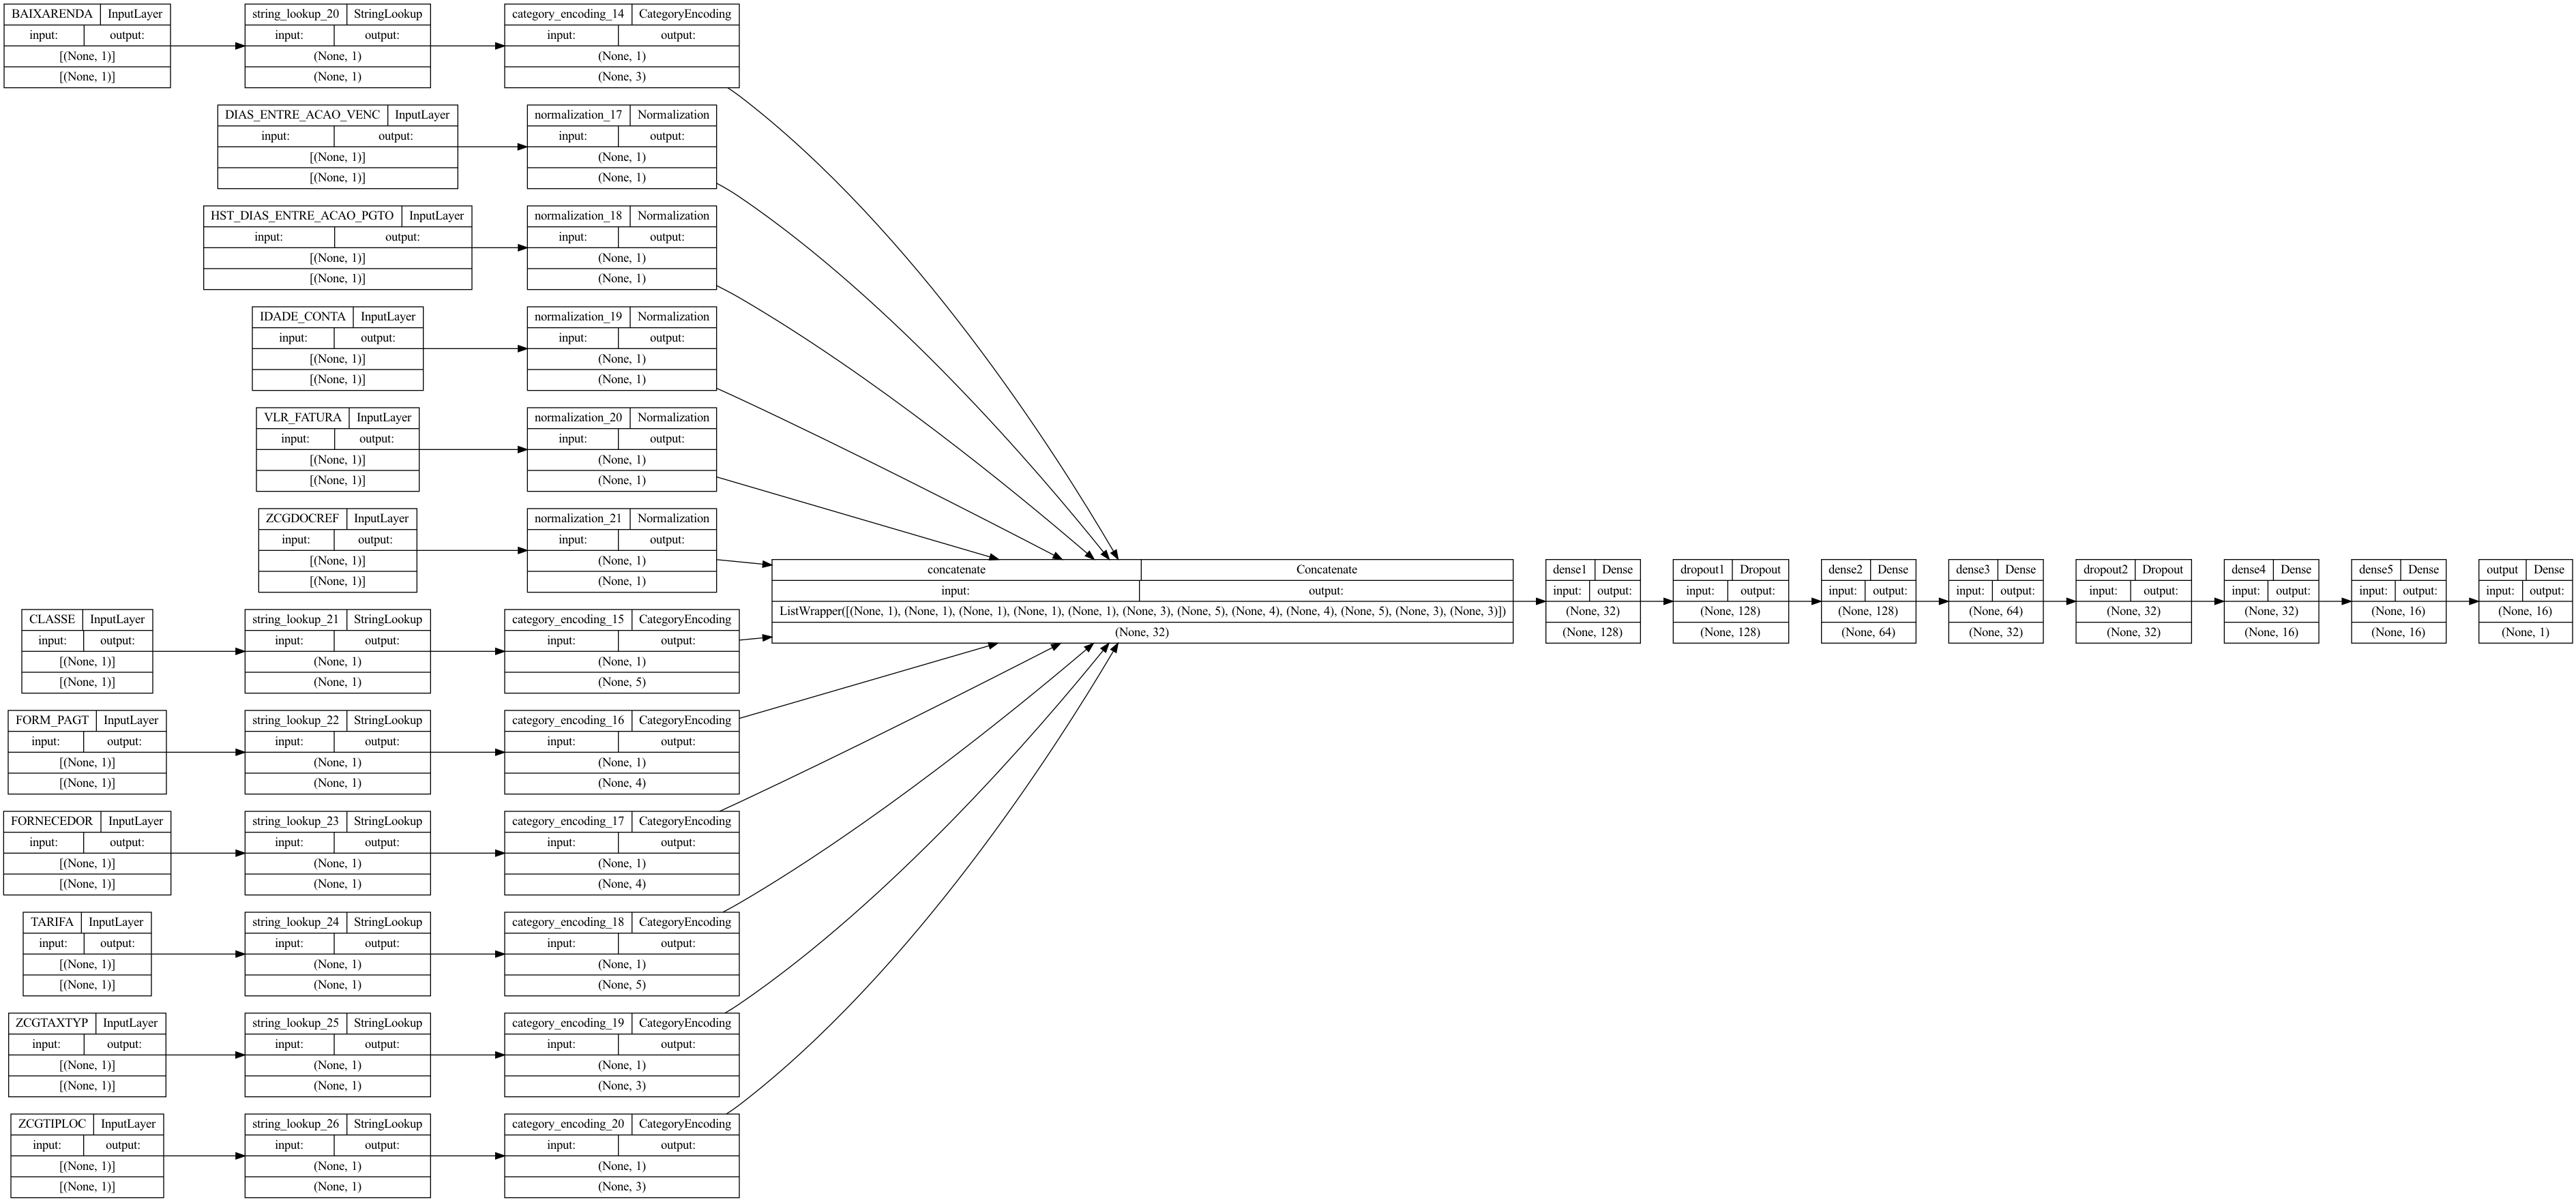

In [130]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [120]:
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='checkpoint_path.keras', monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir=r'./logs')
]

history = model.fit(train_ds, epochs=50, callbacks=callbacks_list)

Epoch 1/50
12834/12834 [==============================] - 1127s 16ms/step - loss: 0.5112 - accuracy: 0.7810
Epoch 2/50
12834/12834 [==============================] - 859s 9ms/step - loss: 0.5058 - accuracy: 0.7823
Epoch 3/50


KeyboardInterrupt: 

In [132]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [133]:
data_url = ("https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz")
raw_data = pd.read_csv(data_url, header=None)

print(f"Dataset shape: {raw_data.shape}")
raw_data.head()

Dataset shape: (581012, 55)


0    1   2    3    4     5    6    7    8     9   ...  45  46  47  48  \
0  2596   51   3  258    0   510  221  232  148  6279  ...   0   0   0   0   
1  2590   56   2  212   -6   390  220  235  151  6225  ...   0   0   0   0   
2  2804  139   9  268   65  3180  234  238  135  6121  ...   0   0   0   0   
3  2785  155  18  242  118  3090  238  238  122  6211  ...   0   0   0   0   
4  2595   45   2  153   -1   391  220  234  150  6172  ...   0   0   0   0   

   49  50  51  52  53  54  
0   0   0   0   0   0   5  
1   0   0   0   0   0   5  
2   0   0   0   0   0   2  
3   0   0   0   0   0   2  
4   0   0   0   0   0   5  

[5 rows x 55 columns]

In [134]:
soil_type_values = [f"soil_type_{idx+1}" for idx in range(40)]
wilderness_area_values = [f"area_type_{idx+1}" for idx in range(4)]

soil_type = raw_data.loc[:, 14:53].apply(lambda x: soil_type_values[0::1][x.to_numpy().nonzero()[0][0]], axis=1)
wilderness_area = raw_data.loc[:, 10:13].apply(lambda x: wilderness_area_values[0::1][x.to_numpy().nonzero()[0][0]], axis=1)

CSV_HEADER = [
    "Elevation",
    "Aspect",
    "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points",
    "Wilderness_Area",
    "Soil_Type",
    "Cover_Type",
]

data = pd.concat(
    [raw_data.loc[:, 0:9], wilderness_area, soil_type, raw_data.loc[:, 54]],
    axis=1,
    ignore_index=True,
)
data.columns = CSV_HEADER

# Convert the target label indices into a range from 0 to 6 (there are 7 labels in total).
data["Cover_Type"] = data["Cover_Type"] - 1

print(f"Dataset shape: {data.shape:,}")
data.head().T


train_splits, test_splits = [], []


for _, group_data in data.groupby("Cover_Type"):
    random_selection = np.random.rand(len(group_data.index)) <= 0.85
    train_splits.append(group_data[random_selection])
    test_splits.append(group_data[~random_selection])

train_data = pd.concat(train_splits).sample(frac=1).reset_index(drop=True)
test_data = pd.concat(test_splits).sample(frac=1).reset_index(drop=True)

print(f"Train split size: {len(train_data.index):,}")
print(f"Test split size: {len(test_data.index):,}")


train_data_file = "train_data.csv"
test_data_file = "test_data.csv"

train_data.to_csv(train_data_file, index=False)
test_data.to_csv(test_data_file, index=False)

Dataset shape: (581012, 13)
Train split size: 493792
Test split size: 87220


In [ ]:
numerical_features_names = [
    'DIAS_ENTRE_ACAO_VENC', 
    'HST_DIAS_ENTRE_ACAO_PGTO', 
    'IDADE_CONTA', 
    'VLR_FATURA', 
    'ZCGDOCREF',
]

categorical_features_names = [
    'BAIXARENDA',
    'CLASSE',
    'FORM_PAGT',
    'FORNECEDOR',
    'TARIFA',
    'ZCGTAXTYP',
    'ZCGTIPLOC',
]
target_feature_name = 'FLG_ACAO_EFICAZ'

In [146]:
TARGET_FEATURE_NAME = 'FLG_ACAO_EFICAZ'

TARGET_FEATURE_LABELS = ['0', '1']

NUMERIC_FEATURE_NAMES = [
    'DIAS_ENTRE_ACAO_VENC', 
    'HST_DIAS_ENTRE_ACAO_PGTO', 
    'IDADE_CONTA', 
    'VLR_FATURA', 
    'ZCGDOCREF',
]
CATEGORICAL_FEATURE_NAMES = [
    'BAIXARENDA',
    'CLASSE',
    'FORM_PAGT',
    'FORNECEDOR',
    'TARIFA',
    'ZCGTAXTYP',
    'ZCGTIPLOC',
]
reduced_train = reduced_train.astype(
    {
        **{num_feat: float for num_feat in NUMERIC_FEATURE_NAMES},
        **{cat_feat: str for cat_feat in CATEGORICAL_FEATURE_NAMES},
        **{target_feat: str for target_feat in [TARGET_FEATURE_NAME]},
    }
)


CATEGORICAL_FEATURES_WITH_VOCABULARY = get_categorical_features_vocab(reduced_train, CATEGORICAL_FEATURE_NAMES)
# {
#     "Soil_Type": list(data["Soil_Type"].unique()),
#     "Wilderness_Area": list(data["Wilderness_Area"].unique()),
# }


FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES
CSV_HEADER = FEATURE_NAMES + [TARGET_FEATURE_NAME]

COLUMN_DEFAULTS = [
    [0] if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME] else ["NA"]
    for feature_name in CSV_HEADER
]

NUM_CLASSES = len(TARGET_FEATURE_LABELS)

In [156]:
reduced_train.to_csv(train_data_file, index=False)

In [ ]:
tf.data.experimental.

In [136]:
def get_dataset_from_csv(csv_file_path, batch_size, shuffle=False):

    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=True,
        shuffle=shuffle,
    )
    return dataset.cache()

In [162]:
learning_rate = 0.001
dropout_rate = 0.1
batch_size = 265
num_epochs = 50
hidden_units = [32, 32]


def run_experiment(model, train_dataset):

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=['accuracy', tf.keras.metrics.AUC()],
    )

    # train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)
    # test_dataset = get_dataset_from_csv(test_data_file, batch_size)

    print("Start training the model...")
    history = model.fit(train_dataset, epochs=num_epochs, callbacks=callbacks_list)
    return history, model
    
#     print("Model training finished")
#     _, accuracy = model.evaluate(test_dataset, verbose=0)

#     print(f"Test accuracy: {accuracy:.2%}")

In [148]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

In [149]:
from tensorflow.keras.layers import StringLookup


def encode_inputs(inputs, use_embedding=False):
    encoded_features = []
    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            # Create a lookup to convert string values to an integer indices.
            # Since we are not using a mask token nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and  num_oov_indices to 0.
            lookup = StringLookup(
                vocabulary=vocabulary,
                mask_token=None,
                num_oov_indices=0,
                output_mode="int" if use_embedding else "binary",
            )
            if use_embedding:
                # Convert the string input values into integer indices.
                encoded_feature = lookup(inputs[feature_name])
                embedding_dims = int(math.sqrt(len(vocabulary)))
                # Create an embedding layer with the specified dimensions.
                embedding = layers.Embedding(
                    input_dim=len(vocabulary), output_dim=embedding_dims
                )
                # Convert the index values to embedding representations.
                encoded_feature = embedding(encoded_feature)
            else:
                # Convert the string input values into a one hot encoding.
                encoded_feature = lookup(tf.expand_dims(inputs[feature_name], -1))
        else:
            # Use the numerical features as-is.
            encoded_feature = tf.expand_dims(inputs[feature_name], -1)

        encoded_features.append(encoded_feature)

    all_features = layers.concatenate(encoded_features)
    return all_features

In [153]:
class Classifier(tf.keras.Model):
    
    def __init__(self, num_classes: int = 2):
        
        super().__init__()
        
        num_units, activation = num_classes, 'softmax'
        classification_model = 'multiclass'
        
        if num_classes == 2:
            num_units, activation = 1, 'sigmoid'
            classification_model = 'binary'
        
        print(
            f'Detected {classification_model} classification problem!\n'
            + '-' * 25 
            + '\n' 
            + f'Model activation: {activation}\n'
        )
        self.dense = layers.Dense(num_units, activation=activation)
  
    def call(self, inputs):
        return self.dense(inputs)


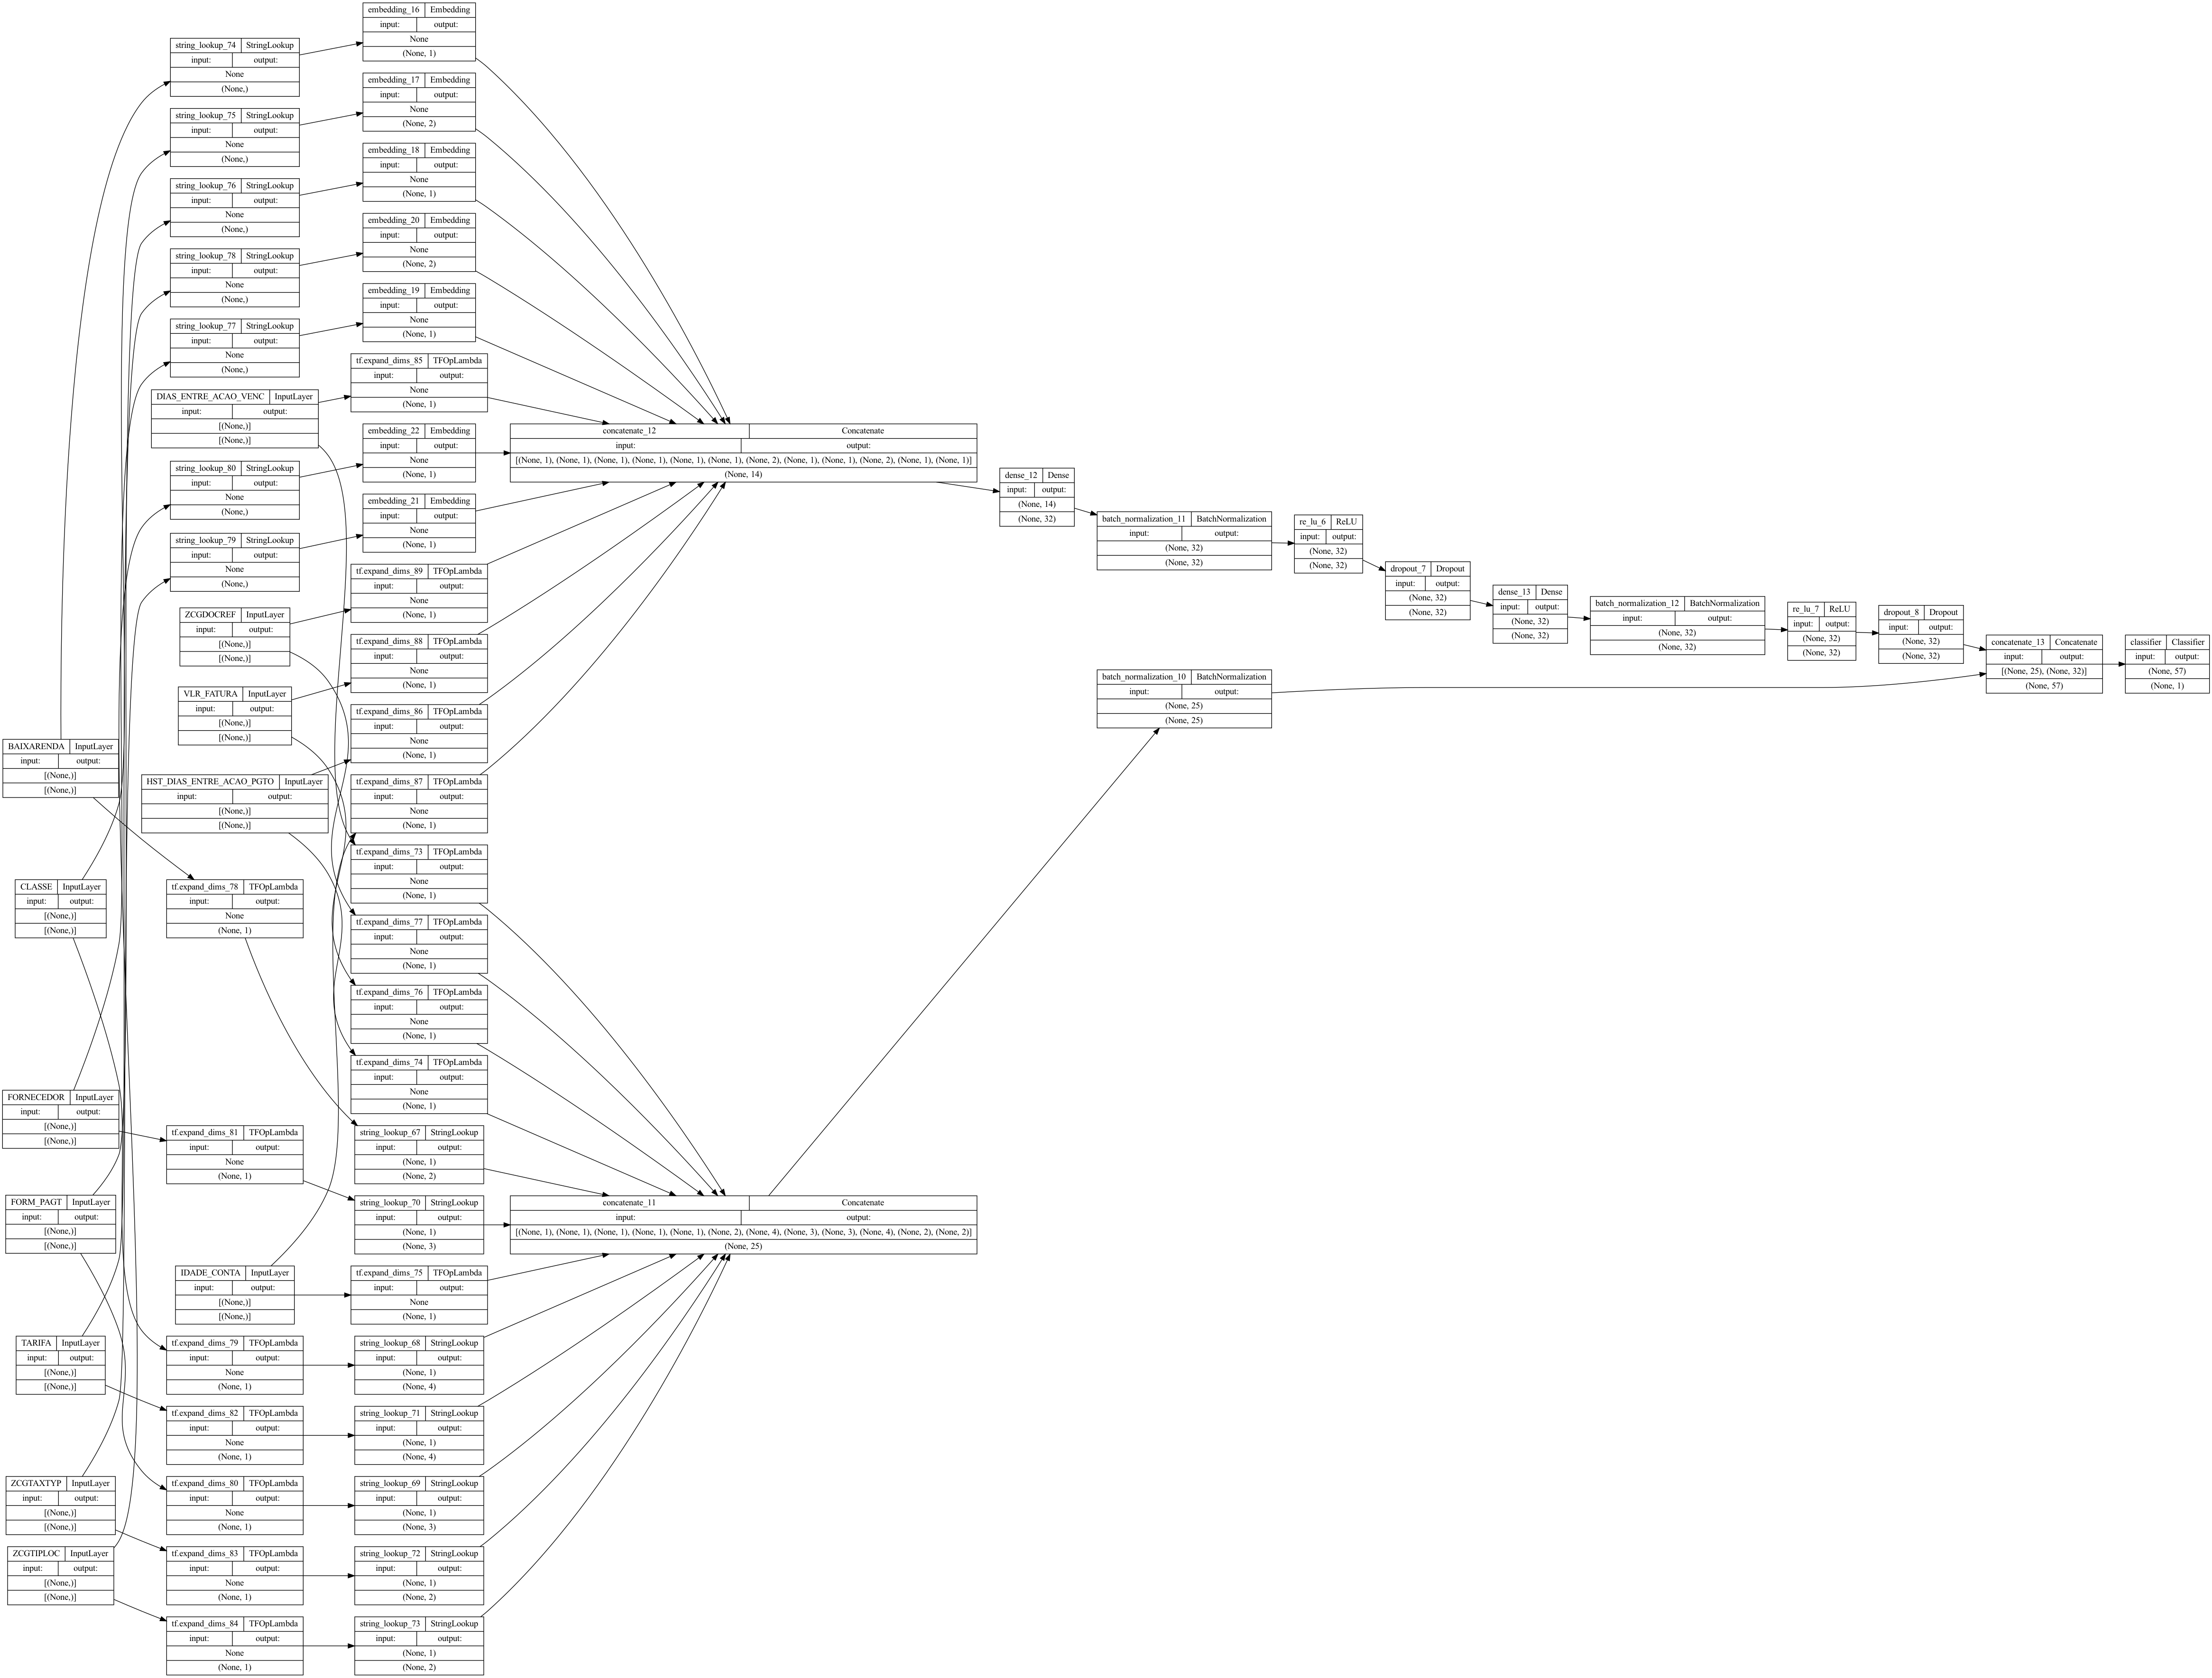

In [155]:
def create_wide_and_deep_model():

    inputs = create_model_inputs()
    wide = encode_inputs(inputs)
    wide = tf.keras.layers.BatchNormalization()(wide)

    deep = encode_inputs(inputs, use_embedding=True)
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([wide, deep])
    outputs = Classifier(num_classes=NUM_CLASSES)(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


wide_and_deep_model = create_wide_and_deep_model()
keras.utils.plot_model(wide_and_deep_model, show_shapes=True, rankdir="LR")

In [163]:
history, model = run_experiment(wide_and_deep_model, train_ds)

Start training the model...
Epoch 1/50


/opt/anaconda3/envs/pyml/lib/python3.8/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['FLG_ACAO_EFICAZ'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


3851/3851 [==============================] - 281s 31ms/step - loss: 0.5185 - accuracy: 0.7755 - auc_1: 0.6151
Epoch 2/50
3851/3851 [==============================] - 249s 37ms/step - loss: 0.5091 - accuracy: 0.7807 - auc_1: 0.6324
Epoch 3/50
3851/3851 [==============================] - 240s 31ms/step - loss: 0.5052 - accuracy: 0.7821 - auc_1: 0.6427
Epoch 4/50
3851/3851 [==============================] - 196s 21ms/step - loss: 0.5040 - accuracy: 0.7822 - auc_1: 0.6465
Epoch 5/50
3851/3851 [==============================] - 196s 26ms/step - loss: 0.5033 - accuracy: 0.7823 - auc_1: 0.6494
Epoch 6/50
3851/3851 [==============================] - 185s 28ms/step - loss: 0.5030 - accuracy: 0.7827 - auc_1: 0.6497
Epoch 7/50
3851/3851 [==============================] - 212s 28ms/step - loss: 0.5024 - accuracy: 0.7822 - auc_1: 0.6520
Epoch 8/50
3851/3851 [==============================] - 216s 29ms/step - loss: 0.5022 - accuracy: 0.7825 - auc_1: 0.6521
Epoch 9/50
3851/3851 [=====================

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print(f"Model Accuracy: {accuracy:,2%}")

In [ ]:
class Classifier(tf.keras.Model):
  
    def __init__(self, num_classes: int = 2):
        
        super().__init__()
        
        if num_classes == 2:
            num_units = 1 
            activation = 'sigmoid'
            
        else:
            num_units = num_classes
            activation = 'softmax'
        
        self.dense = layers.Dense(num_units, activation=activation)
  
    def call(self, inputs):
        return self.dense(inputs)

## Callbacks

Callbacks are special objects that get automatically get executed, when a certain event happens. Even though callbacks 
are widely known and used for building machine Learning and deep learning models, they are also used for various other applications.
As a matter of fact, the name "Callback" represents a design pattern, attributed to any object that gets executed based on 
a certain event. Most common events are the end or start of a program execution, when certain program reaches some predefined state, or 
anything that can be considered as an event.

When referring to deep learning models, callbacks are usually deployed to help on gathering metrics during the training stage of a model. 
Below you'll find a short summary of some of the most frequently used callbacks, for deep learning models.

### ModelCheckpoint

**ModelCheckpoint**, lets you continually save the model during training. Optionally, it allows you to save 
only the current best model so far. In other words, you can use this callback to keep the version of the model 
that achieved the best performance at the end of a given epoch).


### EarlyStopping

The **EarlyStopping callback** interrupts training once a target metric being monitored has stopped improving for a fixed number of epochs. 
For instance, this callback allows you to interrupt training as soon as you start overfitting, thus avoiding having to retrain your 
model for a smaller number of epochs. This callback is typically used in combination with **ModelCheckpoint**, which lets you continually 
save the model during training, as previously stated.


### TensorBoard

TensorBoard (www.tensorflow.org/tensorboard) is a browser-based application that you can run locally. 
It’s the best way to monitor everything that goes on inside your model during training. With TensorBoard, you can:

* Visually monitor metrics during training
* Visualize your model architecture
* Visualize histograms of activations and gradients
* Explore embeddings in 3D

If you’re monitoring more information than just the model’s final loss, you can develop a clearer vision of what the model does 
and doesn’t do, and you can make progress more quickly.

To install TensorBoard, execute the following `pip install` command:

```console

$ pip install tensorboard

```

After training your model, given that you've successfully executed the `pip install` mentioned above, you can start its server, by 
executing the command:

```console

$ tensorboard --logdir /full_path_to_your_log_dir

```

Before executing the `tensorboard` command, make sure to change the `"/full_path_to_your_log_dir"` option for the directory you've added
to the TensorBoard callback.

For me personally, I like to save the results to a folder named `'./logs'`, relative to the same directory being used to run the model.